In [12]:
import os, glob
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob as glob
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm_notebook
from PIL import Image

In [3]:
def create_unet( input_size=(512,512,1)):
    inputs = Input(input_size)
        
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

  

In [33]:
def add_colored_mask(image, mask_image):
    image = cv2.imread(image)
    image = cv2.resize(image, (512,512))
    mask_image = cv2.imread(mask_image)
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)    
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret


def test_load_image(test_file, target_size=(512,512)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(512,512)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)
        filename, fileext = os.path.splitext(os.path.basename(result_file))
        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))  
        cv2.imwrite(result_file, img) 

In [15]:
# if new test: 
# copy files to test dir
# launch clean script
def clean_script():  
  count = len(os.listdir(clean_dir))
  for i in os.listdir(clean_dir):
    filepath = os.path.join(clean_dir, i)
    os.remove(filepath)
  print ('remove '+str(count)+' files.')
clean_script()

remove 6 files.


In [22]:
clean_dir = os.path.join(test_dir, 'test_resize')
main_dir = '/home/alex/medical_project/fluro'
test_dir = os.path.join(main_dir, 'test')
result_dir = os.path.join(test_dir, 'result')
lung_predict = os.path.join(result_dir, 'lung')
clav_predict = os.path.join(result_dir, 'clav')
heart_predict = os.path.join(result_dir, 'heart')
should_predict = os.path.join(result_dir, 'should')
predict_dir = [lung_predict, clav_predict,\
               heart_predict, should_predict]
for i in tqdm_notebook(predict_dir):
    if os.path.exists(i) == False:
        os.mkdir(i)
    else:
        print (i+' already exists')

/home/alex/medical_project/fluro/test/result/lung already exists
/home/alex/medical_project/fluro/test/result/clav already exists
/home/alex/medical_project/fluro/test/result/heart already exists



In [37]:
weights_dir = '/home/alex/medical_project/fluro/weights'
weights = glob(weights_dir+ '/*.hdf5')
lung_model = os.path.join(weights_dir, 'lungs_512_200_2.hdf5')
heart_model = os.path.join(weights_dir, 'heart_512_200.hdf5')
clav_model = os.path.join(weights_dir, 'clavicles_512_100.hdf5')
should_model = os.path.join(weights_dir, 'shoulders_512_200.hdf5')

In [18]:
test_dir = '/home/alex/medical_project/fluro/test'
test_files = glob(test_dir+'/*.png')
for i in tqdm_notebook(test_files):
    if i.endswith('.png'):     
        image = cv2.imread(i)
        image = cv2.resize(image, (512, 512))
        name = os.path.basename(i)
        savepath = os.path.join(clean_dir, name)
        cv2.imwrite(savepath, image)   

In [31]:
clean_dir = os.path.join(test_dir, 'test_resize')
test_files = glob(clean_dir+'/*png')
print (len(test_files))

6


In [34]:
def make_prediction(model_path, save_path):
    test_files = glob(clean_dir+'/*png')
    test_gen = test_generator(test_files, target_size=(512,512))
    model = create_unet()
    model.load_weights(model_path)
    results = model.predict_generator(test_gen, len(test_files), verbose=1)
    save_result(save_path, results, test_files)

In [38]:
# make_prediction(lung_model, lung_predict)
# make_prediction(heart_model, heart_predict)
make_prediction(clav_model, clav_predict)
make_prediction(should_model, should_predict)

6/6 [==============================] - 41s 7s/step


In [52]:
lung_mask  = sorted(glob(lung_predict+'/*'))
heart_mask  = sorted(glob(heart_predict+'/*'))
clav_mask = sorted(glob(clav_predict+'/*'))
should_mask = sorted(glob(should_predict+'/*'))
images = sorted(test_files)

In [48]:
def plot_images(a,b,c, mask_name): 
    fig, axs = plt.subplots(1, 3, figsize=(10, 7))
    axs[0].imshow(add_colored_mask(images[a], mask_name[a]))
    axs[0].set_title(os.path.basename(images[a]))
    axs[1].imshow(add_colored_mask(images[b], mask_name[b]))
    axs[1].set_title(os.path.basename(images[b]))
    axs[2].imshow(add_colored_mask(images[c], mask_name[c]))
    axs[2].set_title(os.path.basename(images[c]))  

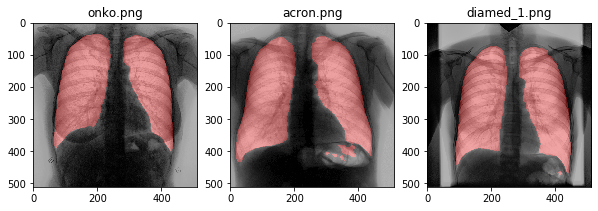

In [74]:
plot_images(5,1,2,lung_mask)

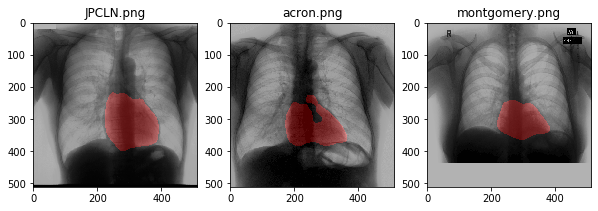

In [70]:
plot_images(0,1,4,heart_mask)

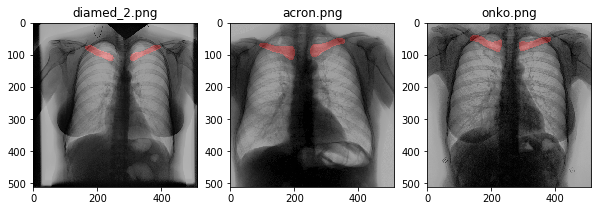

In [76]:
plot_images(3,1,5,clav_mask)

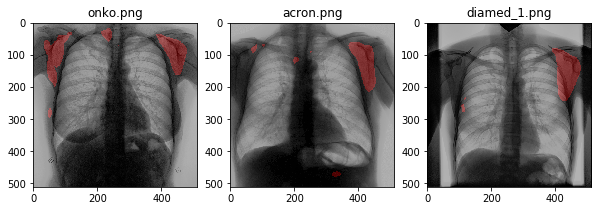

In [63]:
plot_images(5,1,2,should_mask)